In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import Series

import numpy as np
import matplotlib.pyplot as plt

### 设置路径

In [2]:
path_pre = '../../'
path_original_dataset = path_pre + 'original-dataset/'
path_intermediate_dataset = path_pre + 'intermediate-dataset/'
path_submission_dataset = path_pre + 'submission-dataset/'
path_modeling_dataset = path_pre + 'modeling-dataset/'
path_model = path_pre + 'model/'

### 划分数据集

In [3]:
from scipy.sparse import load_npz

In [4]:
X = load_npz(path_modeling_dataset + 'X_linear.npz')
y = np.load(path_modeling_dataset + 'y.npy')

In [5]:
# 直接取后面 20% 的数据作为测试集
train_size = int(np.shape(X)[0] * 0.8)
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

### 以 validation_curve 调参

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import validation_curve
from sklearn.metrics import make_scorer, log_loss

In [7]:
def plot_validation_curve(train_scores, valid_scores, param_range, xlabel, figsize=(8,6), logspace=False):
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    valid_scores_mean = np.mean(valid_scores, axis=1)
    valid_scores_std = np.std(valid_scores, axis=1)
    plt.figure(figsize=figsize)
    plt.title("Validation Curve")
    plt.xlabel(xlabel)
    plt.ylabel("Score")
    # plt.ylim(-0.20, -0.23)
    lw = 2
    if logspace:
        plt.semilogx(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    else:
        plt.plot(param_range, train_scores_mean, label="Training score", color="darkorange", lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="darkorange", lw=lw)
    if logspace:
        plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    else:
        plt.plot(param_range, valid_scores_mean, label="Cross-validation score", color="navy", lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.2,
                     color="navy", lw=lw)
    plt.legend(loc="best")
    for a,b in zip(param_range, valid_scores_mean): 
        plt.text(a, b, str(b))
    plt.show()

In [8]:
loss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

#### alpha

In [10]:
from sklearn.model_selection import TimeSeriesSplit

In [11]:
tscv = TimeSeriesSplit(n_splits=10)
generator = tscv.split(X_train)
print('数据集划分：')
for train, test in tscv.split(X_train):
    print("%s %s" % (np.shape(train), np.shape(test)))

数据集划分：
(164823,) (164817,)
(329640,) (164817,)
(494457,) (164817,)
(659274,) (164817,)
(824091,) (164817,)
(988908,) (164817,)
(1153725,) (164817,)
(1318542,) (164817,)
(1483359,) (164817,)
(1648176,) (164817,)


In [19]:
param_range = np.logspace(-4, 0, 5)
generator = tscv.split(X_train)
clf = SGDClassifier(loss='log', n_jobs=-1)
train_scores, valid_scores = \
    validation_curve(clf, X_train, y_train, 'alpha', param_range, cv=generator, scoring=loss, n_jobs=-1)

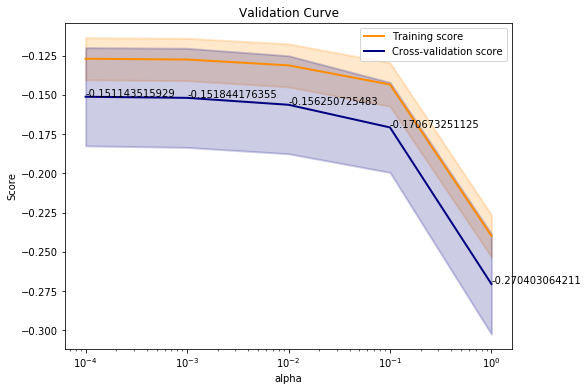

In [20]:
plot_validation_curve(train_scores, valid_scores, param_range=param_range, xlabel='alpha', logspace=True)

#### n_iter

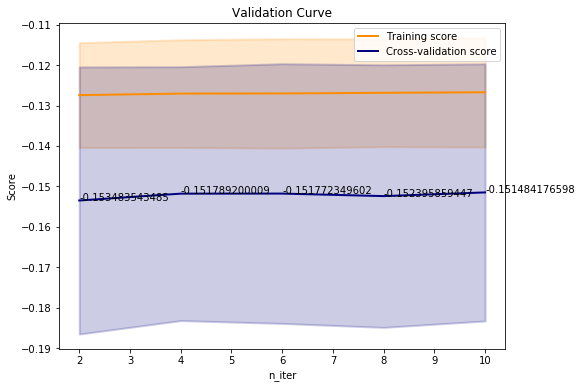

In [21]:
param_range = np.linspace(2, 10, num=5)
generator = tscv.split(X_train)
clf = SGDClassifier(loss='log', n_jobs=-1, alpha=0.0001)
train_scores, valid_scores = \
    validation_curve(clf, X_train, y_train, 'n_iter', param_range, cv=generator, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, param_range, 'n_iter')

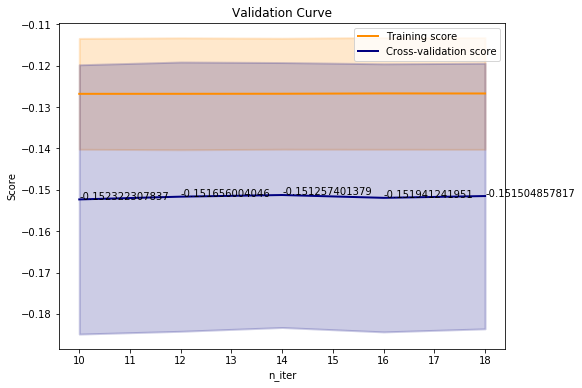

In [22]:
param_range = np.linspace(10, 18, num=5)
generator = tscv.split(X_train)
clf = SGDClassifier(loss='log', n_jobs=-1, alpha=0.0001)
train_scores, valid_scores = \
    validation_curve(clf, X_train, y_train, 'n_iter', param_range, cv=generator, scoring=loss, n_jobs=-1)
plot_validation_curve(train_scores, valid_scores, param_range, 'n_iter')

### 评价

In [23]:
clf = SGDClassifier(loss='log', n_jobs=-1, alpha=0.0001, n_iter=14)

In [24]:
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=14, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [25]:
# 观察训练集上的情况
y_pred_train = clf.predict_proba(X_train)
log_loss(y_train, y_pred_train)

0.14307008877809724

0.14884455796980808

In [26]:
# 观察测试集上的情况
y_pred_test = clf.predict_proba(X_test)
log_loss(y_test, y_pred_test)

0.23029663389937838

0.22725621053071626

In [83]:
from sklearn.model_selection import learning_curve

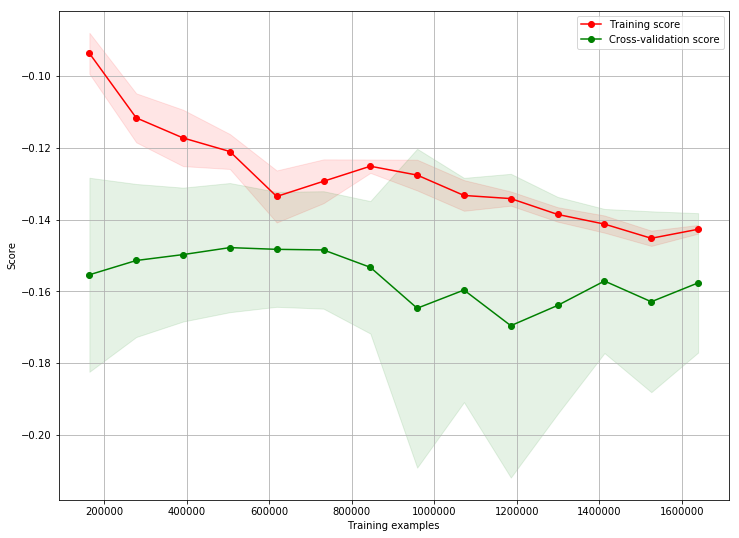

In [84]:
train_sizes=np.linspace(.1, 1.0, 14)
train_sizes_abs, train_scores, test_scores = \
    learning_curve(clf, X_train, y_train, cv=10, n_jobs=-1, train_sizes=train_sizes, scoring=loss)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12,9))
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std, \
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.legend(loc="best")
plt.show()

### 保存模型

In [28]:
from sklearn.externals import joblib

In [29]:
joblib.dump(clf, path_model + 'sgd_lr.pkl') 

['../../model/sgd_lr.pkl']

### GridSearchCV

In [9]:
from sklearn.model_selection import GridSearchCV

In [16]:
alphas = np.logspace(-7, -1, 7)
generator = tscv.split(X_train)

In [17]:
param_grid = {'alpha': alphas}
clf = GridSearchCV(SGDClassifier(loss='log', n_jobs=-1), param_grid, cv=generator, scoring=loss, n_jobs=-1)

In [18]:
clf.fit(X_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f9b5af47a98>,
       error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'alpha': array([  1.00000e-07,   1.00000e-06,   1.00000e-05,   1.00000e-04,
         1.00000e-03,   1.00000e-02,   1.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(log_loss, greater_is_better=False, needs_proba=True),
       verbose=0)

In [44]:
cv_results_df = DataFrame(clf.cv_results_)
cv_results_df.rename(columns={'mean_train_score': 'mean_train_loss', 'mean_test_score': 'mean_val_loss', 'rank_test_score': 'rank_val_loss'}, inplace=True)
cv_results_df[['mean_val_loss', 'mean_train_loss']] = -cv_results_df[['mean_val_loss', 'mean_train_loss']]
cv_results_df

,mean_fit_time,mean_score_time,mean_val_loss,mean_train_loss,param_alpha,params,rank_val_loss,split0_test_score,split0_train_score,split1_test_score,...,split7_test_score,split7_train_score,split8_test_score,split8_train_score,split9_test_score,split9_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,13.890171,0.318655,1.280443,1.121606,1e-07,{'alpha': 1e-07},7,-1.094131,-0.717339,-0.921722,...,-0.995222,-0.736729,-0.996672,-0.865595,-3.199193,-3.586558,11.780494,0.341318,0.690967,0.826670
1,6.911387,0.155488,0.243634,0.193063,1e-06,{'alpha': 1e-06},6,-0.492552,-0.307111,-0.268897,...,-0.218941,-0.164598,-0.215473,-0.161642,-0.158611,-0.157426,4.047640,0.046442,0.100569,0.051875
2,7.050935,0.163438,0.157877,0.130525,1e-05,{'alpha': 1e-05},4,-0.161096,-0.105886,-0.128722,...,-0.167533,-0.138555,-0.183898,-0.142947,-0.155975,-0.147570,3.619164,0.037019,0.033960,0.011424
3,7.016449,0.149110,0.152718,0.126960,0.0001,{'alpha': 0.0001},2,-0.136928,-0.095739,-0.120899,...,-0.164831,-0.137013,-0.180954,-0.139749,-0.153032,-0.143492,3.781672,0.036258,0.033692,0.013396
4,6.843598,0.163037,0.152377,0.127394,0.001,{'alpha': 0.001},1,-0.138901,-0.096109,-0.120579,...,-0.164079,-0.137629,-0.180750,-0.140430,-0.153852,-0.144203,3.660713,0.037740,0.032164,0.013510
5,6.961415,0.170080,0.156307,0.131165,0.01,{'alpha': 0.01},3,-0.139991,-0.099677,-0.122155,...,-0.167408,-0.141710,-0.188417,-0.144516,-0.156221,-0.148448,3.589770,0.053655,0.031177,0.013739
6,5.925679,0.128256,0.170665,0.143327,0.1,{'alpha': 0.1},5,-0.143934,-0.113054,-0.130310,...,-0.182489,-0.154546,-0.205178,-0.157363,-0.181700,-0.161939,2.683855,0.035409,0.028673,0.013851


In [45]:
cv_results_df[['param_alpha', 'mean_train_loss', 'mean_val_loss', 'rank_val_loss']]

,param_alpha,mean_train_loss,mean_val_loss,rank_val_loss
0,1e-07,1.121606,1.280443,7
1,1e-06,0.193063,0.243634,6
2,1e-05,0.130525,0.157877,4
3,0.0001,0.126960,0.152718,2
4,0.001,0.127394,0.152377,1
5,0.01,0.131165,0.156307,3
6,0.1,0.143327,0.170665,5


In [46]:
-clf.score(X=X_test, y=y_test)

0.2289754993577173